In [13]:
import glob
from PIL import Image
import matplotlib.pyplot as plt
import os
import sqlite3
from sqlite3 import Error
import io
import base64
import numpy as np
from sklearn import preprocessing
from collections import Counter
import time

#### DUMMY DATA

In [23]:
imageFolderPath = "/Volumes/NTFS Partition/Datasets/Face Rec/CASIA/MTCNN_160"
databasePath = "/Volumes/NTFS Partition/Datasets/Face Rec/MSCeleb/people.db"

op_mode = 'both'
dataset_type = 'f'
dataset_file = imageFolderPath
#dataset_file = databasePath
size_train = 100
min_count = 10
max_count = 20
size_test = 200

#### LOAD DATASETS

In [8]:
# 1.2 B
# TODO: fix query so that there is an upper limit to image per subject (MED PRIORITY),
#       test set not loading (HIGH PRIORITY)

def process_database(conn, dataset, size, min_count, max_count):
    
    """
        INPUTS:
        
                 conn: sqlite3 db connection
              dataset: String ('train' || 'test')
                 size: int (required number of samples)
            min_count: int (minimum number of training images per subject)
            max_count: int (maximum number of training images per subject, default = 10)
        
        OUTPUTS:
        
            x: np.array(size, img_height, img_weight, 3)
            y: np.array(size,)
    
    """
    
    print("\t1.2B: LOADING " + dataset.upper() + " SET IMAGES FROM DATABASE")
    
    x, y = [], []
        
    cursor = conn.cursor()
    
    start = time.time() 
        
    # RETRIEVE SUBJECTS
    
    query = """SELECT i.person_id, i.image
    FROM ((datasets d
    INNER JOIN images i ON d.image_id = i.id)
    INNER JOIN people p ON i.person_id = p.id)
    WHERE d.name = ?
    GROUP BY i.person_id
    HAVING COUNT(i.image) > ?
    LIMIT ?;"""
    
    cursor.execute(query, (set_type, min_count, size))   
    rows = cursor.fetchall()
    
    query = """SELECT i.person_id, 
    
    """
    
    # RETRIEVE SUBJECT IMAGES
    
    stop = time.time()
    
    print("\t1.2B: QUERIED " + str(len(rows)) + " TUPLES FROM DATABASE: " + str(stop - start)[:7] + " s")
    
    for i in range(len(rows)):
        image = Image.open(io.BytesIO(rows[i][1]))
        image = image.resize((160, 160), Image.ANTIALIAS)
        image_arr = np.array(image)
        label = int(rows[i][0])
        x.append(image_arr)
        y.append(label)
    
    cursor.close()
    
    """
    le = preprocessing.LabelEncoder().fit(y)
    n_classes = le.classes_
    target_status = " SET (TARGET SET SIZE NOT MET):"
    min_image_count = 1

    if (len(x) == size):
        target_status = " SET (TARGET SET SIZE MET):"
        
    if (dataset == 'train'):
        min_image_count = min_count
    
    print("\t1.2B: ADDED " + str(len(x)) + " SAMPLES TO " + dataset.upper() + target_status + "\n" +
          "\t\tIMAGE SHAPE: " + str(x[0].shape) + "\n" +
          "\t\tSUBJECT COUNT: " + str(len(le.classes_)) + "\n" +
          "\t\tMIN IMAGE COUNT PER SUBJECT: " + str(min_image_count) + "\n" +
          "\t\tMAX IMAGE COUNT PER SUBJECT: " + str(max_count))
    """
    
    return np.array(x), np.array(y)

In [9]:
# 1.1 B

def create_connection(db_file):
    
    try:
        conn = sqlite3.connect(db_file)
        print("\t1.1B: CONNECTED TO DATABASE: " + db_file)
        return conn
    
    except Error as e:
        print("\t1.1B: FAILED TO CONNECT TO DATABASE: " + db_file)
        print(e)
    
    return None

In [10]:
# 1.1 A

def process_image_folder(dataset_file, dataset, size, min_count, max_count):
    
    """
        INPUTS:
        
            dataset_file: String (path to dataset directory)
                 dataset: String ('train' || 'test')
                    size: int (number of samples)
               min_count: int (minimum number of training images per subject, default = 1)
               max_count: int (maximum number of training images per subject, default = 10)
        
        OUTPUTS:
        
            x: np.array(size, img_height, img_weight, 3)
            y: np.array(size,)
    
    """
    
    print("\t1.1A: LOADING " + dataset.upper() + " SET IMAGES FROM FILE SYSTEM: " + dataset_file)
    
    start = time.time()
     
    x, y, set_complete = [], [], False
    folders = os.listdir(dataset_file)[1:]
    
    for folder in folders:
        
        if set_complete:
            break
            
        _,_,files = next(os.walk(dataset_file + '/' + folder))
        
        if dataset == 'train':
            if len(files) < 2 * min_count:
                continue
                
        for i in range(len(files)):
            
            file = files[i]
            image_path = dataset_file + '/' + folder + '/' + file
            image_arr, label = None, int(folder)
            
            cond_1 = (dataset == 'train') and (int(file[:-4]) % 2 == 0)
            cond_2 = (dataset == 'test') and (int(file[:-4]) % 2 == 1)
            
            if cond_1 or cond_2:
                continue
            
            image = Image.open(image_path)
            image_arr = np.array(image)
            x.append(image_arr)
            y.append(label)
            
            if dataset == 'train':
                print("\t\tTRAIN SET STATUS: (" + str(len(x)) + "/" + str(size) + ")", end = '\r')
                
            if dataset == 'test':
                print("\t\tTEST SET STATUS: (" + str(len(x)) + "/" + str(size) + ")", end = '\r')
                        
            if len(x) >= size:
                set_complete = True
                print("\n\t\tTARGET SET SIZE MET")
                break
            
            if i >= (2 * min_count):
                if i >= (2 * max_count):
                    break
    
    stop = time.time()
    total_time = str(stop - start)[:7]
    
    le = preprocessing.LabelEncoder().fit(y)
    n_classes = le.classes_
    target_status = " SET (TARGET SET SIZE NOT MET): "
    min_image_count = 1
    data = Counter(y)

    if (set_complete):
        target_status = " SET (TARGET SET SIZE MET): "
        
    if (dataset == 'train'):
        min_image_count = min_count
    
    print("\t1.1A: ADDED " + str(len(x)) + " SAMPLES TO " + dataset.upper() + target_status + total_time + " s\n" +
          "\t\tIMAGE SHAPE: " + str(x[0].shape) + "\n" +
          "\t\tSUBJECT COUNT: " + str(len(le.classes_)) + "\n" +
          "\t\tLOWEST IMAGE COUNT PER SUBJECT: " + str(data.most_common()[-1][1]) + "\n" +
          "\t\tHIGHEST IMAGE COUNT PER SUBJECT: " + str(data.most_common()[0][1]))
    
    return np.array(x), np.array(y)

In [11]:
# 1.0

def load_dataset(op_mode, dataset_type, dataset_file, size_train, size_test, min_count = 5, max_count = 10):
    
    """
        INPUTS:
        
                 op_mode: String ('train' || 'test' || 'both')
            dataset_type: String ('f' || 'db')
            dataset_file: String (path to dataset folder/database file)
              size_train: int (# of samples for training set)
               size_test: int (# of samples for test set)
               min_count: int (minimum number of training images per subject, default = 5)
               max_count: int (maximum number of training/testing images per subject, default = 10)
        
        OUTPUTS:
        
                 x_train: np.array(size_train, img_height, img_width, 3)
                 y_train: np.array(size_train,)
                  x_test: np.array(size_test, img_height, img_width, 3)
                  y_test: np.array(size_test,)
                  
    """
    
    print("\n################################## DATASET LOADER ##################################")
    
    x_train, y_train, x_test, y_test = np.array([]), np.array([]), np.array([]), np.array([])
    x_train_summary, y_train_summary = '-', '-'
    x_test_summary, y_test_summary = '-', '-'
    
    if dataset_type == 'f':
        
        print("\n1.0: LOADING DATASET(S) FROM FILE SYSTEM: operation mode = " + op_mode + "\n")
        
        if (op_mode == 'train' or op_mode == 'both'):
            x_train, y_train = process_image_folder(dataset_file, "train", size_train, min_count, max_count)
            x_train_summary, y_train_summary = x_train.shape, y_train.shape
            
        if (op_mode == 'test' or op_mode == 'both'):
            x_test, y_test = process_image_folder(dataset_file, "test", size_test, min_count, max_count)
            x_test_summary, y_test_summary = x_test.shape, y_test.shape
    
    if dataset_type == 'db':
        
        print("\n1.0: LOADING DATASET(S) FROM DATABASE")
        
        conn = create_connection(dataset_file)
        
        if (conn == None):
            print("\n1.0: ERROR - COULD NOT CONNECT TO DATABASE: " + dataset_file + "\n"
                  "\n1.0: TERMINATING")
            return x_train, y_train, x_test, y_test
        
        if (op_mode == 'train' or op_mode == 'both'):
            x_train, y_train = process_database(conn, "train", size_train, min_count, max_count)
            x_train_summary, y_train_summary = x_train.shape, y_train.shape
            
        if (op_mode == 'test' or op_mode == 'both'):
            y_test, y_test = process_database(conn, "test", size_test, min_count, max_count)
            x_test_summary, y_test_summary = x_test.shape, y_test.shape
            
        conn.close()
        
        print("\n1.0: CLOSED DATABASE CONNECTION")
        
    print("\n1.0: DATASET(S) SUMMARY: " + "\n\n" +
          "\tTRAIN SET: " + "\n" +
          "\t\tIMAGES: " + str(x_train_summary) + "\n" +
          "\t\tLABELS: " + str(y_train_summary) + "\n" +
          "\tTEST SET: " + "\n" +
          "\t\tIMAGES: " + str(x_test_summary) + "\n" +
          "\t\tLABELS: " + str(y_test_summary))
            
    return x_train, y_train, x_test, y_test

In [24]:
x_train, y_train, x_test, y_test = load_dataset(op_mode, dataset_type, dataset_file, size_train, size_test, min_count, max_count)





################################## DATASET LOADER ##################################

1.0: LOADING DATASET(S) FROM FILE SYSTEM: operation mode = both

	1.1A: LOADING TRAIN SET IMAGES FROM FILE SYSTEM: /Volumes/NTFS Partition/Datasets/Face Rec/CASIA/MTCNN_160
		TRAIN SET STATUS: (100/100)
		TARGET SET SIZE MET
	1.1A: ADDED 100 SAMPLES TO TRAIN SET (TARGET SET SIZE MET): 3.86322 s
		IMAGE SHAPE: (160, 160, 3)
		SUBJECT COUNT: 6
		LOWEST IMAGE COUNT PER SUBJECT: 3
		HIGHEST IMAGE COUNT PER SUBJECT: 21
	1.1A: LOADING TEST SET IMAGES FROM FILE SYSTEM: /Volumes/NTFS Partition/Datasets/Face Rec/CASIA/MTCNN_160
		TEST SET STATUS: (200/200)
		TARGET SET SIZE MET
	1.1A: ADDED 200 SAMPLES TO TEST SET (TARGET SET SIZE MET): 7.57117 s
		IMAGE SHAPE: (160, 160, 3)
		SUBJECT COUNT: 12
		LOWEST IMAGE COUNT PER SUBJECT: 1
		HIGHEST IMAGE COUNT PER SUBJECT: 21

1.0: DATASET(S) SUMMARY: 

	TRAIN SET: 
		IMAGES: (100, 160, 160, 3)
		LABELS: (100,)
	TEST SET: 
		IMAGES: (200, 160, 160, 3)
		LABELS: (200,)

In [27]:
y_train[89]

105

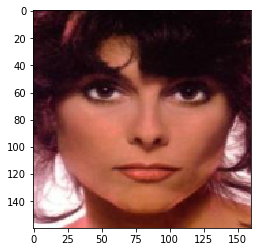

In [28]:
plt.imshow(x_train[89])

In [30]:
y_train[56]

102

In [18]:
y_train

array([ 45,  45,  45,  45,  45,  45,  99,  99,  99,  99,  99,  99, 100,
       100, 100])

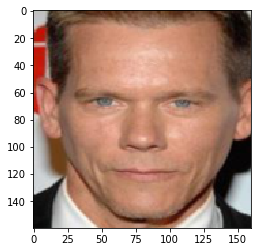

In [31]:
plt.imshow(x_test[56])

In [32]:
x_test[0].shape

(160, 160, 3)